# Stage 1.1

---

### _Content_:

1. Data Generation
2. Preprocessing the dataset
3. Pre-Training Setup
4. Training
5. Evaluation & Visualization
 
### _Requirements_:

1. numpy
2. matplotlib
3. scikit-learn

---

In [395]:
import numpy as np
import matplotlib.pyplot as plt

## 1. Data Generation

In [396]:
# Set a global seed for reproducibility (To get the same random initializations)
# np.random.seed(36)

In [397]:
# Assign the constants
N_SAMPLES = 1000
N_INPUT_FEATURES = 1
N_OUTPUT_FEATURES = 1

In [398]:
def good_initialization(shape):
    output_dim = shape[0]
    input_dim = shape[1]
    std = np.sqrt(2/input_dim)
    return np.random.randn(output_dim, input_dim) * std

In [399]:
NetworkAchitecture = {
    "layer_1": {
        "w": good_initialization(shape=(5, N_INPUT_FEATURES)),
        "b": np.ones(shape=(5,)),
    },
    "layer_2": {
        "w": good_initialization(shape=(10, 5)),
        "b": np.ones(shape=(10,)),
    },
    "layer_3": {
        "w": good_initialization(shape=(N_OUTPUT_FEATURES, 10)),
        "b": np.ones(shape=(N_OUTPUT_FEATURES,)),
    },
}

In [400]:
layer1_w = NetworkAchitecture["layer_1"]["w"]
layer1_b = NetworkAchitecture["layer_1"]["b"]
layer2_w = NetworkAchitecture["layer_2"]["w"]
layer2_b = NetworkAchitecture["layer_2"]["b"]
layer3_w = NetworkAchitecture["layer_3"]["w"]
layer3_b = NetworkAchitecture["layer_3"]["b"]

# Check the shapes of the weights and biases
print(f"Layer 1 Weights shape: {layer1_w.shape}")
print(f"Layer 1 Biases shape: {layer1_b.shape}")
print(f"Layer 2 Weights shape: {layer2_w.shape}")
print(f"Layer 2 Biases shape: {layer2_b.shape}")
print(f"Layer 3 Weights shape: {layer3_w.shape}")
print(f"Layer 3 Biases shape: {layer3_b.shape}")

Layer 1 Weights shape: (5, 1)
Layer 1 Biases shape: (5,)
Layer 2 Weights shape: (10, 5)
Layer 2 Biases shape: (10,)
Layer 3 Weights shape: (1, 10)
Layer 3 Biases shape: (1,)


In [401]:
def interesting_function(x):
    x = np.asarray(x)
    y = 0.3 * x**3 - 2 * x**2 + 4 * x + 5 * np.sin(x) + np.exp(-0.1 * x**2) + 550
    return y

X = np.random.uniform(low=-10.0, high=11.0, size=(N_SAMPLES, 1))
y = interesting_function(X)

In [402]:
# Check the shapes of X and y
print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (1000, 1), y shape: (1000, 1)


In [403]:
X[:3]

array([[-4.94040294],
       [ 9.85296148],
       [-6.19088226]])

In [404]:
y[:3]

array([[450.20592102],
       [680.13427437],
       [377.88150929]])

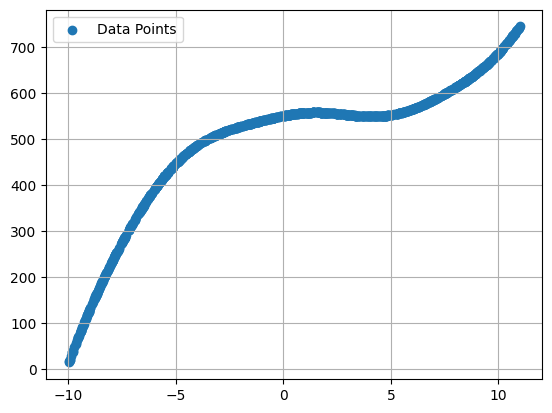

In [405]:
plt.scatter(X, y, label="Data Points")
plt.grid(True)
plt.legend()
plt.show()

## 2. Preprocessing the dataset

In [406]:
from sklearn.model_selection import train_test_split

In [407]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

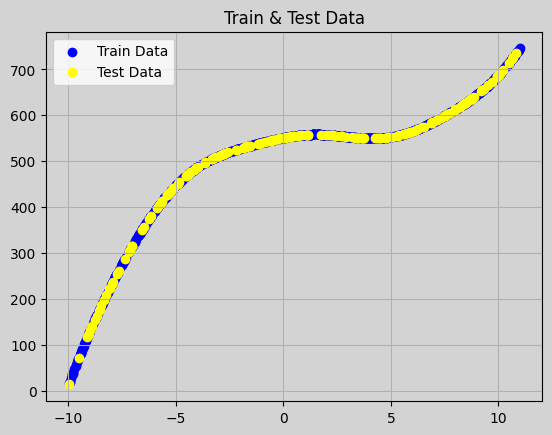

In [408]:
fig, ax = plt.subplots()
fig.patch.set_facecolor("lightgray")
ax.set_facecolor("lightgray")

ax.scatter(X_train, y_train, color="blue", label="Train Data")
ax.scatter(X_test, y_test, color="yellow", label="Test Data")
ax.legend()
ax.grid(True)
ax.set_title("Train & Test Data")

plt.show()

## 3. Pre-Training Setup

Using MSE (Mean Squared Error as a loss function)

In [409]:
def compute_loss(y_pred, y_real):
    if y_pred.shape != y_real.shape:
        raise ValueError(f"Shapes must be equal, got {y_pred.shape} and {y_real.shape}")
    errors = y_pred - y_real
    return np.mean(errors**2)

In [410]:
def relu(X):
    return np.maximum(0, X)


def relu_derivative(X):
    X = np.asarray(X)
    return (X > 0).astype(np.float32)

In [411]:
history = {"epoch": [], "loss": []}

## 4. Training

In [412]:
class Adam:
    def __init__(self, w, b, learning_rate=0.0001, beta_m=0.85, beta_v=0.9):

        self.w = np.asarray(w)
        self.b = np.asarray(b)
        self.lr = learning_rate

        self.beta_m = beta_m
        self.beta_v = beta_v

        self.weight_m = 0
        self.bias_m = 0
        self.weight_prev_m = 0
        self.bias_prev_m = 0

        self.weight_v = 0
        self.bias_v = 0
        self.weight_prev_v = 0
        self.bias_prev_v = 0
        
    def step(self, epoch, w_gradient, b_gradient):
        self.weight_prev_m = self.weight_m
        self.bias_prev_m = self.bias_m
        self.weight_prev_v = self.weight_v
        self.bias_prev_v = self.bias_v
        
        self.weight_m = self.beta_m * self.weight_prev_m + (1 - self.beta_m) * w_gradient
        self.bias_m = self.beta_m * self.bias_prev_m + (1 - self.beta_m) * b_gradient
        
        self.weight_v = self.beta_v * self.weight_prev_v + (1 - self.beta_v) * (w_gradient ** 2)
        self.bias_v = self.beta_v * self.bias_prev_v + (1 - self.beta_v) * (b_gradient ** 2)
        
        # Bias correction
        weight_m_hat = self.weight_m / (1 - self.beta_m ** (epoch + 1))
        bias_m_hat = self.bias_m / (1 - self.beta_m ** (epoch + 1))
        weight_v_hat = self.weight_v / (1 - self.beta_v ** (epoch + 1))
        bias_v_hat = self.bias_v / (1 - self.beta_v ** (epoch + 1))
        
        # Update weights and biases
        self.w -= self.lr * weight_m_hat / (np.sqrt(weight_v_hat) + 1e-8)
        self.b -= self.lr * bias_m_hat / (np.sqrt(bias_v_hat) + 1e-8)
        return self.w, self.b
    
    def get_params(self):
        return {"w": self.w, "b": self.b}


In [413]:
MAX_EPOCHS: int = 5000*3
MIN_LOSS: float = 0.01
LEARNING_RATE: float = 0.006
BETA_1 = 0.9
BETA_2 = 0.95

In [414]:

optimizer_1 = Adam(w=layer1_w, b=layer1_b, learning_rate=LEARNING_RATE, beta_m=BETA_1, beta_v=BETA_2)
optimizer_2 = Adam(w=layer2_w, b=layer2_b, learning_rate=LEARNING_RATE, beta_m=BETA_1, beta_v=BETA_2)
optimizer_3 = Adam(w=layer3_w, b=layer3_b, learning_rate=LEARNING_RATE, beta_m=BETA_1, beta_v=BETA_2)

In [415]:
epoch: int = 0

while True:

    # Forward Pass
    params_1 = optimizer_1.get_params()
    layer1_w = params_1["w"]
    layer1_b = params_1["b"]

    params_2 = optimizer_2.get_params()
    layer2_w = params_2["w"]
    layer2_b = params_2["b"]

    params_3 = optimizer_3.get_params()
    layer3_w = params_3["w"]
    layer3_b = params_3["b"]

    z_1 = X_train @ layer1_w.T + layer1_b
    A_1 = relu(z_1)
    # print("z_1 shape:", z_1.shape)
    # print("A_1 shape:", A_1.shape)

    z_2 = A_1 @ layer2_w.T + layer2_b
    A_2 = relu(z_2)
    # print("z_2 shape:", z_2.shape)
    # print("A_2 shape:", A_2.shape)

    z_3 = A_2 @ layer3_w.T + layer3_b
    A_3 = relu(z_3)
    # print("z_3 shape:", z_3.shape)
    # print("A_3 shape:", A_3.shape)

    y_pred = A_3
    loss = compute_loss(y_pred=y_pred, y_real=y_train)

    if loss <= MIN_LOSS or epoch >= MAX_EPOCHS:
        print("Early stopping condition met.")
        print(f"Training Finishes: Epoch: {epoch} | Loss: {loss}")
        break
        

    # Backward pass

    errors = y_pred - y_train
    loss_gradient = 2 / len(X_train) * errors
    upstream_gradient_3 = loss_gradient * relu_derivative(z_3)
    layer3_w_gradient = upstream_gradient_3.T @ A_2
    layer3_b_gradient = sum(upstream_gradient_3)
    # print(layer3_w_gradient.shape, layer3_w.shape)

    upstream_gradient_2 = upstream_gradient_3 @ layer3_w * relu_derivative(z_2)
    layer2_w_gradient = upstream_gradient_2.T @ A_1
    layer2_b_gradient = sum(upstream_gradient_2)
    # print(layer2_w_gradient.shape, layer2_w.shape)

    upstream_gradient_1 = upstream_gradient_2 @ layer2_w * relu_derivative(z_1)
    layer1_w_gradient = upstream_gradient_1.T @ X_train
    layer1_b_gradient = sum(upstream_gradient_1)
    # print(layer1_w_gradient.shape, layer1_w.shape)

    # Optimization
    optimizer_1.step(
        epoch=epoch, w_gradient=layer1_w_gradient, b_gradient=layer1_b_gradient
    )
    optimizer_2.step(
        epoch=epoch, w_gradient=layer2_w_gradient, b_gradient=layer2_b_gradient
    )
    optimizer_3.step(
        epoch=epoch, w_gradient=layer3_w_gradient, b_gradient=layer3_b_gradient
    )

    history["epoch"].append(epoch)
    history["loss"].append(loss)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss}")
    epoch += 1

Epoch: 0 | Loss: 269043.01468335063
Epoch: 100 | Loss: 195083.7196868928
Epoch: 200 | Loss: 71715.88802745045
Epoch: 300 | Loss: 44744.05387454072
Epoch: 400 | Loss: 11091.395533133684
Epoch: 500 | Loss: 1527.365955484836
Epoch: 600 | Loss: 819.7543809522143
Epoch: 700 | Loss: 328.43575691168036
Epoch: 800 | Loss: 113.75668775546136
Epoch: 900 | Loss: 56.48343655182533
Epoch: 1000 | Loss: 47.58604273268784
Epoch: 1100 | Loss: 44.40737025157965
Epoch: 1200 | Loss: 42.415462585032394
Epoch: 1300 | Loss: 40.2224318705936
Epoch: 1400 | Loss: 38.57999379792906
Epoch: 1500 | Loss: 37.03836576015396
Epoch: 1600 | Loss: 35.03619142994625
Epoch: 1700 | Loss: 33.6471876194851
Epoch: 1800 | Loss: 32.55957336113762
Epoch: 1900 | Loss: 31.409806298604558
Epoch: 2000 | Loss: 30.54476009279061
Epoch: 2100 | Loss: 29.639188347917234
Epoch: 2200 | Loss: 28.73034974263792
Epoch: 2300 | Loss: 28.05091340869279
Epoch: 2400 | Loss: 27.07620247641752
Epoch: 2500 | Loss: 26.16670971718182
Epoch: 2600 | Loss:

## 5. Evaluation & Visualization

### Training

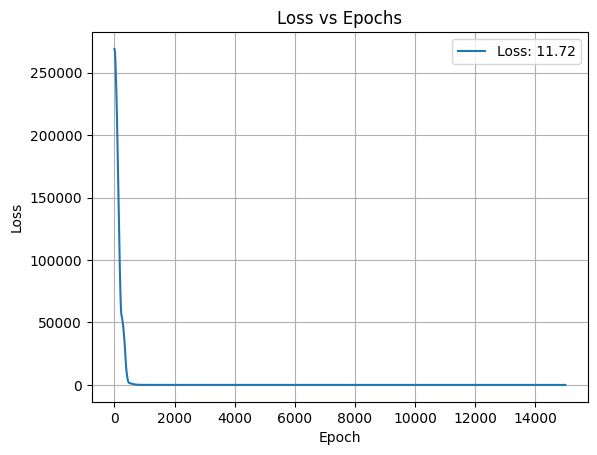

In [416]:
plt.plot(history["epoch"], history["loss"], label=f"Loss: {loss:.2f}")
plt.title("Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

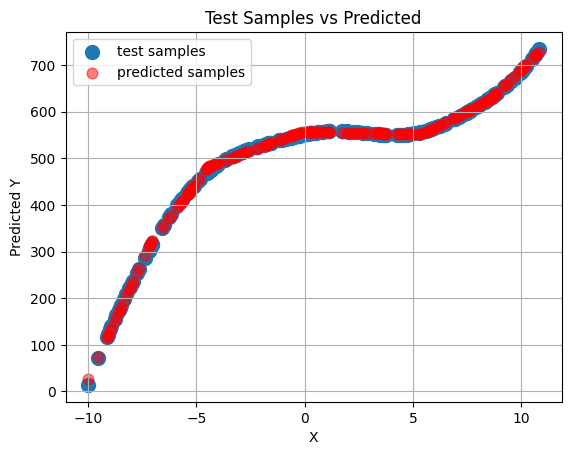

In [417]:
y_pred_test = (
    relu(relu(X_test @ layer1_w.T + layer1_b) @ layer2_w.T + layer2_b) @ layer3_w.T
    + layer3_b
)

plt.scatter(X_test, y_test, label="test samples", s=100)

plt.scatter(
    X_test, relu(y_pred_test), label="predicted samples", color="red", alpha=0.5, s=60
)

plt.title("Test Samples vs Predicted")
plt.xlabel("X")
plt.ylabel("Predicted Y")
plt.grid()
plt.legend()
plt.show()